# IMPORTS

## Libs

In [1]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LogisticRegression
from category_encoders.count import CountEncoder
from sklearn.ensemble        import ExtraTreesClassifier, RandomForestClassifier
from sklearn.preprocessing   import MinMaxScaler, StandardScaler
import xgboost as xgb
import unicodedata
import inflection

import json
import pickle
import requests
import numpy as np
import pandas as pd
# import xgboost as xgb
import seaborn as sns
# import psycopg2 as pg
# import scikitplot as skplt
import pandas.io.sql as psql
import matplotlib.pyplot as plt

from IPython.display      import Image
from IPython.core.display import HTML

from sklearn.model_selection import train_test_split
from sklearn.preprocessing   import MinMaxScaler, StandardScaler
from sklearn.neighbors       import KNeighborsClassifier
from sklearn.linear_model    import LogisticRegression
from sklearn.ensemble        import ExtraTreesClassifier, RandomForestClassifier
from sklearn.preprocessing import PowerTransformer

from sklearn.model_selection import cross_val_score
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn import tree
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

import warnings

warnings.filterwarnings( 'ignore' )

## Helper Function

In [2]:
def jupyter_settings():
    %matplotlib inline
    
    plt.style.use( 'bmh' )
    plt.rcParams['figure.figsize'] = [12, 8]
    plt.rcParams['font.size'] = 24
    sns.set_palette("Reds") 
    
    display(HTML( '<style>.container { width:100% !important; }</style>'))
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option( 'display.expand_frame_repr', False )
    
    sns.set()

In [3]:
jupyter_settings()

## Carregamento dos Dados

In [4]:
train = pd.read_csv('../data/train.csv', encoding='utf-8')
test = pd.read_csv('../data/test.csv',  encoding='utf-8')

In [5]:
train.head()

,id,Classificação do hotel,Meses da reserva até o check-in,Número de pernoites reservadas,Número de hospedes,Regime de alimentação,Nacionalidade,Forma de Reserva,Já se hospedou anterioremente,Tipo do quarto reservado,Reserva feita por agência de turismo,Reserva feita por empresa,Reserva com Estacionamento,Reserva com Observações,Reserva Cancelada
0,33571,5 estrelas,5,5,2.0,Café da manha e jantar,France,Agência,Não,Amethyst,Sim,Não,Sim,Nenhuma,0
1,82458,4 estrelas,167,3,2.0,Café da manha,Spain,Agência,Não,Amethyst,Sim,Não,Não,Nenhuma,1
2,94061,4 estrelas,4,3,2.0,Café da manha,Belgium,Agência,Não,Amethyst,Sim,Não,Não,1 a 3,0
3,75196,4 estrelas,13,2,2.0,Café da manha,Spain,Agência,Não,Amethyst,Sim,Não,Não,Nenhuma,1
4,82940,4 estrelas,4,2,2.0,Café da manha,Spain,Agência,Não,Amethyst,Sim,Não,Não,Nenhuma,1


# DESCRIÇÃO DOS DADOS

In [6]:
# Concatenate train and test together
all_data = pd.concat([train, test])

## Renomeando Colunas

In [7]:
all_data.columns = [c.replace(' ', '_') for c in all_data.columns]

cols_old = all_data.columns

snakecase = lambda x: inflection.underscore(x)

cols_new = list(map(snakecase, cols_old))

#rename
all_data.columns = cols_new

# Split back into train and test
train = all_data[all_data['id'].isin(train['id'])]
test = all_data[all_data['id'].isin(test['id'])].drop('reserva_cancelada', axis=1)

## Dimensão dos dados

In [8]:
print('Train shape:', train.shape)
print('Test shape:', test.shape)

Train shape: (72159, 15)
Test shape: (48106, 14)


## Tipo dos dados

In [9]:
train.dtypes

id                                        int64
classificação_do_hotel                   object
meses_da_reserva_até_o_check_in           int64
número_de_pernoites_reservadas            int64
número_de_hospedes                      float64
regime_de_alimentação                    object
nacionalidade                            object
forma_de_reserva                         object
já_se_hospedou_anterioremente            object
tipo_do_quarto_reservado                 object
reserva_feita_por_agência_de_turismo     object
reserva_feita_por_empresa                object
reserva_com_estacionamento               object
reserva_com_observações                  object
reserva_cancelada                       float64
dtype: object

## Checagem de valores nulos

In [10]:
train.isna().sum()

id                                         0
classificação_do_hotel                     0
meses_da_reserva_até_o_check_in            0
número_de_pernoites_reservadas             0
número_de_hospedes                         3
regime_de_alimentação                      0
nacionalidade                           1093
forma_de_reserva                           0
já_se_hospedou_anterioremente              0
tipo_do_quarto_reservado                   0
reserva_feita_por_agência_de_turismo       0
reserva_feita_por_empresa                  0
reserva_com_estacionamento                 0
reserva_com_observações                    0
reserva_cancelada                          0
dtype: int64

In [11]:
train['número_de_hospedes'].fillna(train['número_de_hospedes'].median(), inplace=True)
train['nacionalidade'].fillna('Outros', inplace=True)

## Análise descritiva

In [12]:
num_attributes = train.select_dtypes(include=['int64', 'float64'])
cat_attributes = train.select_dtypes(exclude=['int64', 'float64', 'datetime64[ns]'])

### Atributos numéricos

In [13]:
# Central Tendency - mean, mediana, 25%, 75% // dispersion - std, min, max, 
ctd1 = num_attributes.describe()

#dispersion - range, skew, kurtosis
d1 = pd.DataFrame(num_attributes.apply(lambda x: x.max() - x.min())).T
d2 = pd.DataFrame(num_attributes.apply(lambda x: x.skew())).T
d3 = pd.DataFrame(num_attributes.apply(lambda x: x.kurtosis())).T

#join
medidas = pd.concat([ctd1, d1, d2, d3]).T.reset_index()
medidas.columns = ['attributes', 'count','mean', 'std', 'min', '25%', 'median', '75%', 'max', 'range', 'skew', 'kurtosis']


medidas

,attributes,count,mean,std,min,25%,median,75%,max,range,skew,kurtosis
0,id,72159.0,60093.687787,34726.028006,1.0,30013.5,60080.0,90301.0,120265.0,120264.0,0.000051,-1.203219
1,meses_da_reserva_até_o_check_in,72159.0,7.145928,25.852330,1.0,1.0,3.0,6.0,311.0,310.0,8.667253,79.725538
2,número_de_pernoites_reservadas,72159.0,15.824152,98.248479,0.0,2.0,3.0,4.0,1172.0,1172.0,8.765012,80.204284
3,número_de_hospedes,72159.0,14.258263,96.444195,0.0,2.0,2.0,2.0,1153.0,1153.0,8.723448,79.668050
4,reserva_cancelada,72159.0,0.370418,0.482920,0.0,0.0,0.0,1.0,1.0,1.0,0.536675,-1.712028


<Figure size 3000x6000 with 0 Axes>

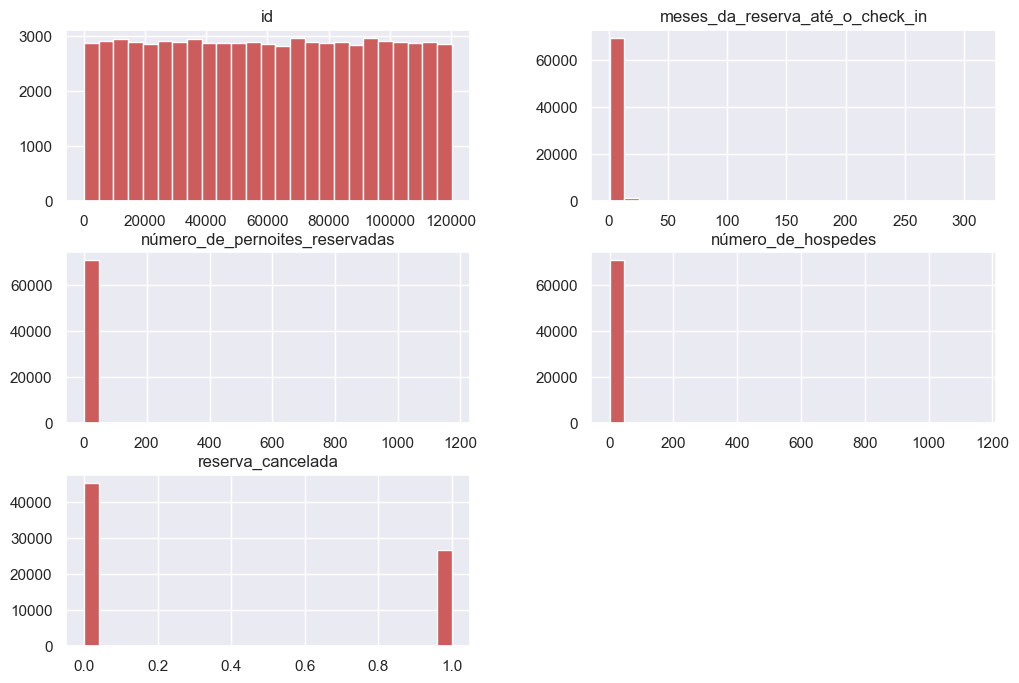

In [14]:
plt.figure(figsize = (30,60))
num_attributes.hist(bins= 25, color= 'indianred');

### Atributos categóricos

In [15]:
cat_attributes.apply(lambda x: x.unique().shape[0])

classificação_do_hotel                    2
regime_de_alimentação                     4
nacionalidade                           170
forma_de_reserva                          3
já_se_hospedou_anterioremente             2
tipo_do_quarto_reservado                 10
reserva_feita_por_agência_de_turismo      2
reserva_feita_por_empresa                 2
reserva_com_estacionamento                2
reserva_com_observações                   3
dtype: int64

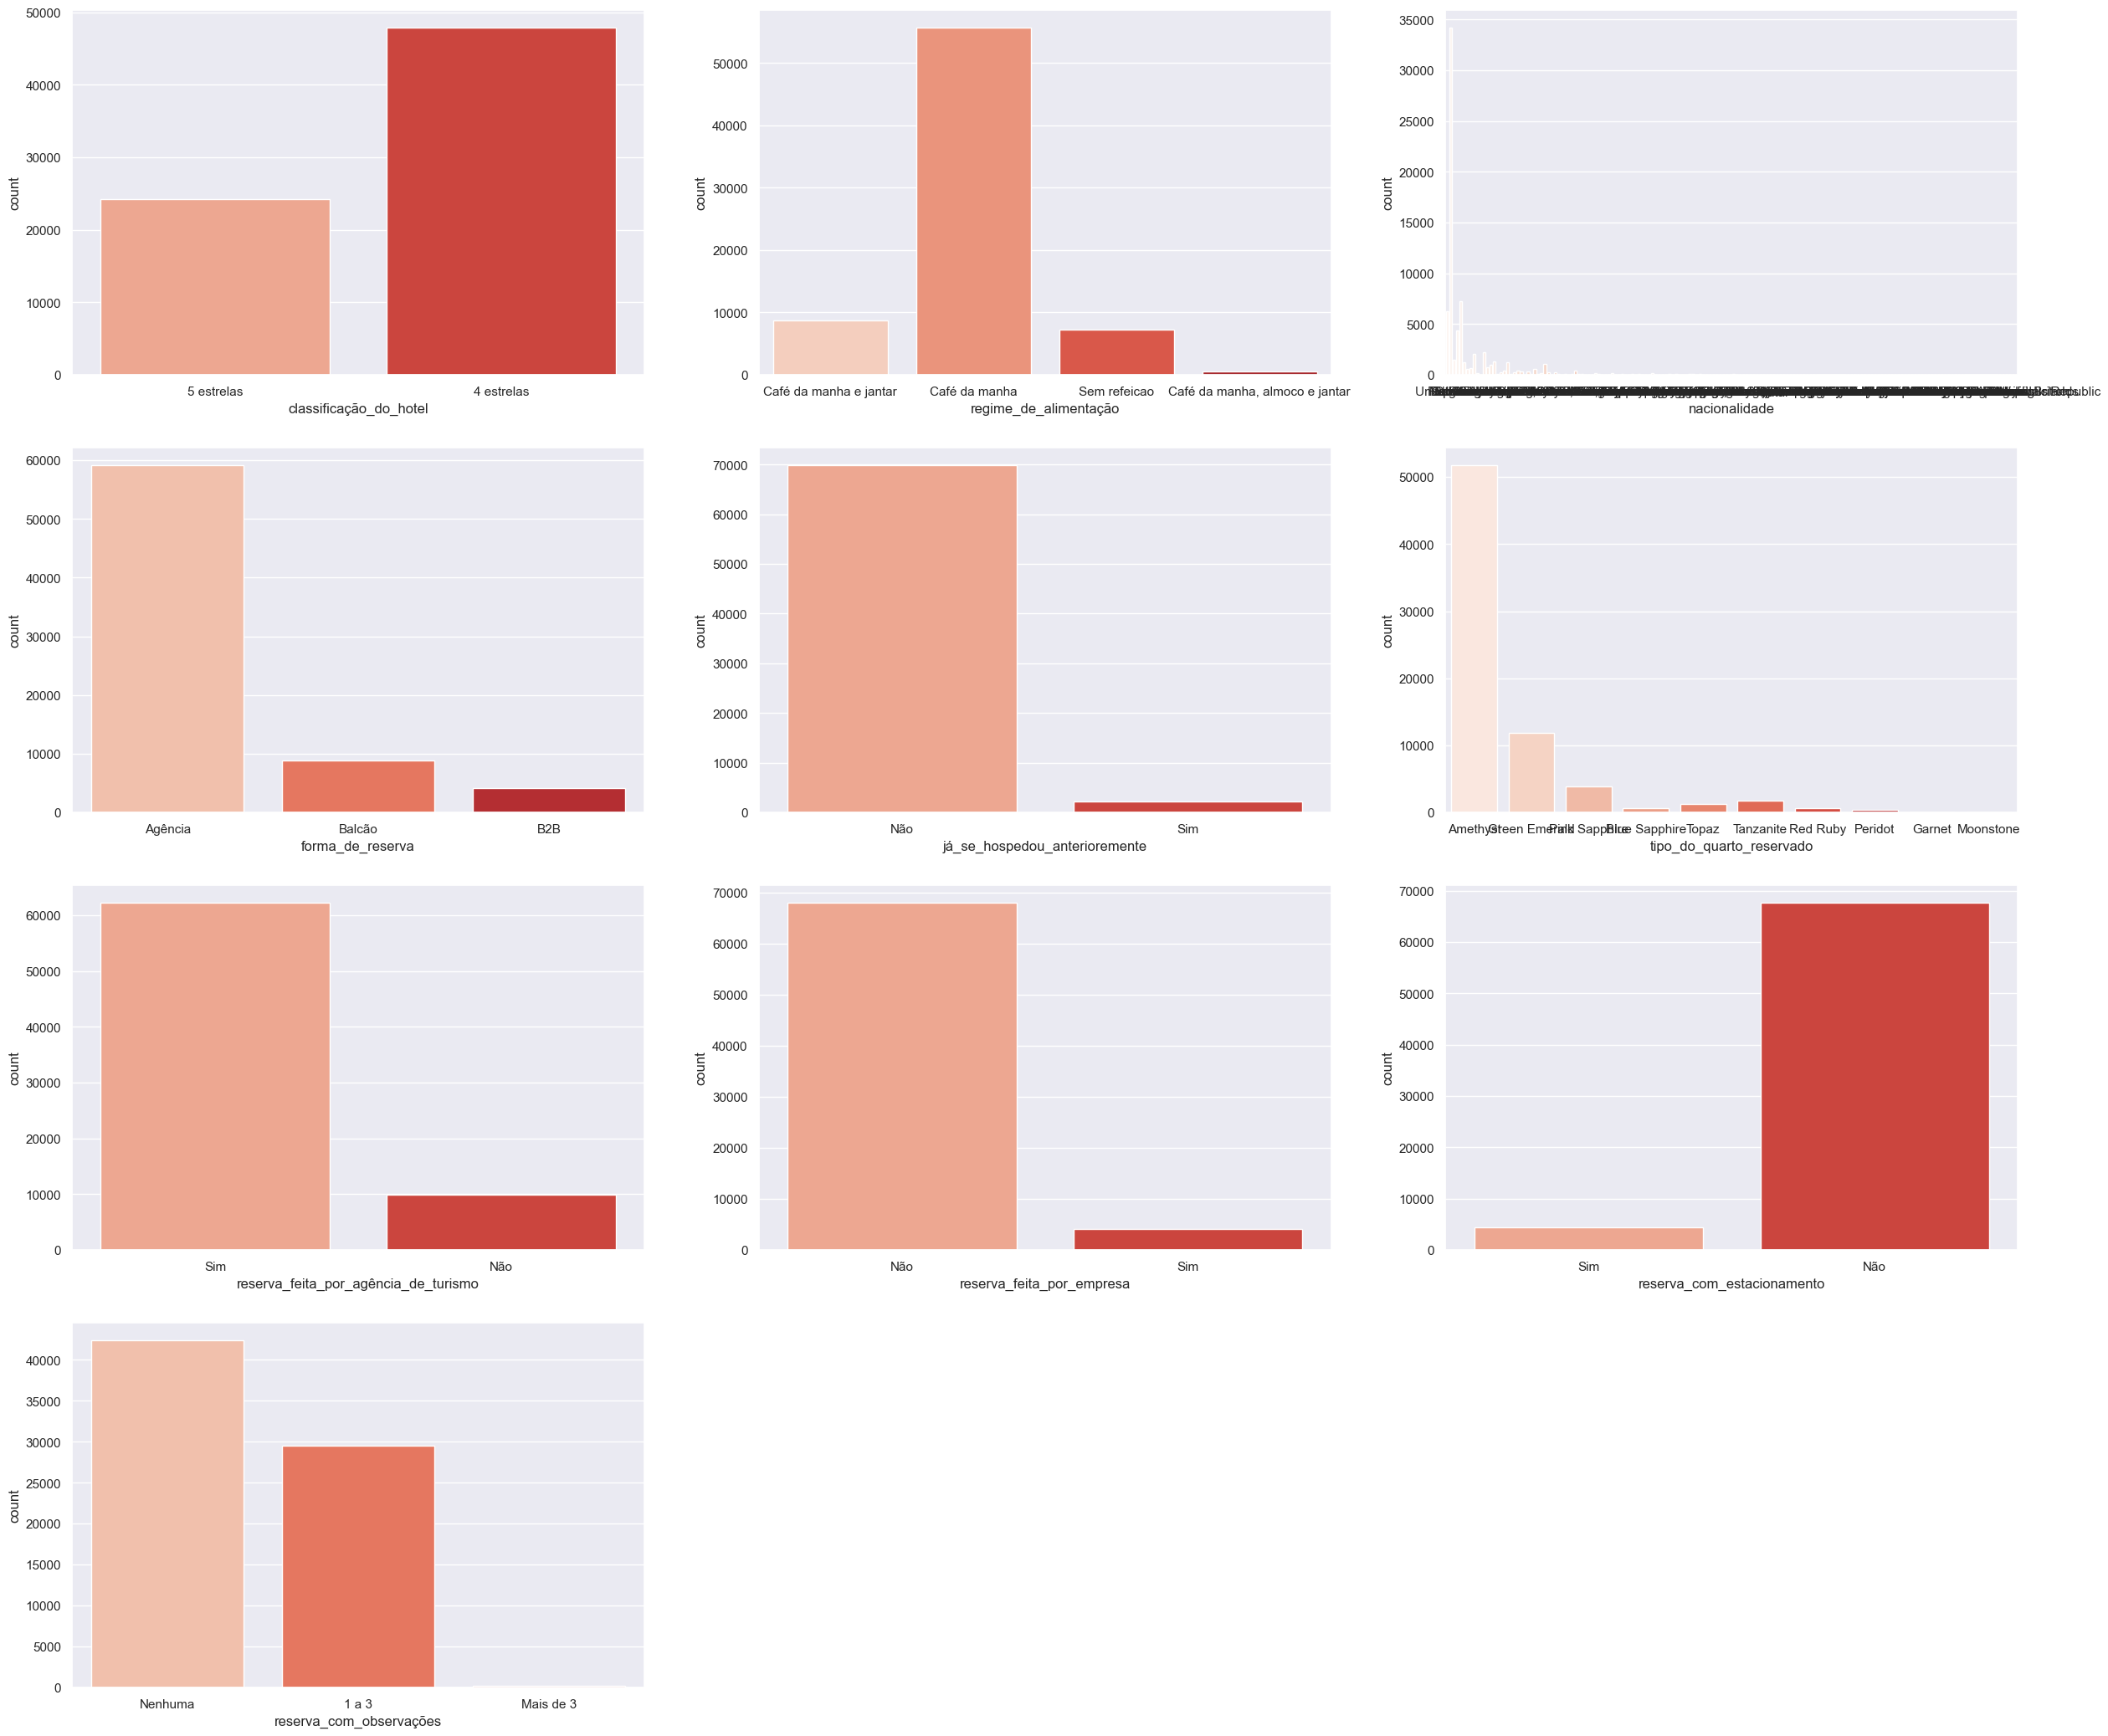

In [16]:
plt.figure(figsize = (30,60))

x = 1
for d in cat_attributes:
    plt.subplot(9, 3, x)
    sns.countplot( x=d, data=train, palette = 'Reds')
    x += 1

# FEATURE ENGINEERING

In [17]:
tx_cancel_nacionalidade = train.groupby('nacionalidade')['reserva_cancelada'].mean().reset_index().rename(columns={'reserva_cancelada': 'tx_cancel_nacionalidade'})
tx_cancel_regime_de_alimentação = train.groupby('regime_de_alimentação')['reserva_cancelada'].mean().reset_index().rename(columns={'reserva_cancelada': 'tx_cancel_regime_de_alimentação'})
tx_cancel_forma_da_reserva = train.groupby('forma_de_reserva')['reserva_cancelada'].mean().reset_index().rename(columns={'reserva_cancelada': 'tx_cancel_forma_de_reserva'})
tx_cancel_tipo_do_quarto_reservado = train.groupby('tipo_do_quarto_reservado')['reserva_cancelada'].mean().reset_index().rename(columns={'reserva_cancelada': 'tx_cancel_tipo_do_quarto_reservado'})
tx_cancel_reserva_com_observações = train.groupby('reserva_com_observações')['reserva_cancelada'].mean().reset_index().rename(columns={'reserva_cancelada': 'tx_cancel_reserva_com_observações'})

train = pd.merge(train, tx_cancel_nacionalidade, how="left", on=["nacionalidade", "nacionalidade"])
train = pd.merge(train, tx_cancel_regime_de_alimentação, how="left", on=["regime_de_alimentação", "regime_de_alimentação"])
train = pd.merge(train, tx_cancel_forma_da_reserva, how="left", on=["forma_de_reserva", "forma_de_reserva"])
train = pd.merge(train, tx_cancel_tipo_do_quarto_reservado, how="left", on=["tipo_do_quarto_reservado", "tipo_do_quarto_reservado"])
train = pd.merge(train, tx_cancel_reserva_com_observações, how="left", on=["reserva_com_observações", "reserva_com_observações"])

In [18]:
train['reserva_feita_por_agência_de_turismo_bin'] = train['reserva_feita_por_agência_de_turismo'].apply(lambda x: 1 if x == 'Sim' else 0)
train['reserva_feita_por_empresa_bin'] = train['reserva_feita_por_empresa'].apply(lambda x: 1 if x == 'Sim' else 0)
train['reserva_com_estacionamento_bin'] = train['reserva_com_estacionamento'].apply(lambda x: 1 if x == 'Sim' else 0)
train['classificação_do_hotel_bin'] = train['classificação_do_hotel'].apply(lambda x: 1 if x == '5 estrelas' else 0)   

# 4 EDA

## Análise univariada var resposta

In [19]:
train['reserva_cancelada'].value_counts(normalize=True).reset_index().rename(columns={'index': 'reserva_cancelada', 'reserva_cancelada': 'pctg'})

,reserva_cancelada,pctg
0,0.0,0.629582
1,1.0,0.370418


## Análise bivariada

In [20]:
num_attributes.columns

Index(['id', 'meses_da_reserva_até_o_check_in',
       'número_de_pernoites_reservadas', 'número_de_hospedes',
       'reserva_cancelada'],
      dtype='object')

### Numéricas

In [21]:
print(train['id'].min())
train['id'].max()

1


120265

<AxesSubplot:>

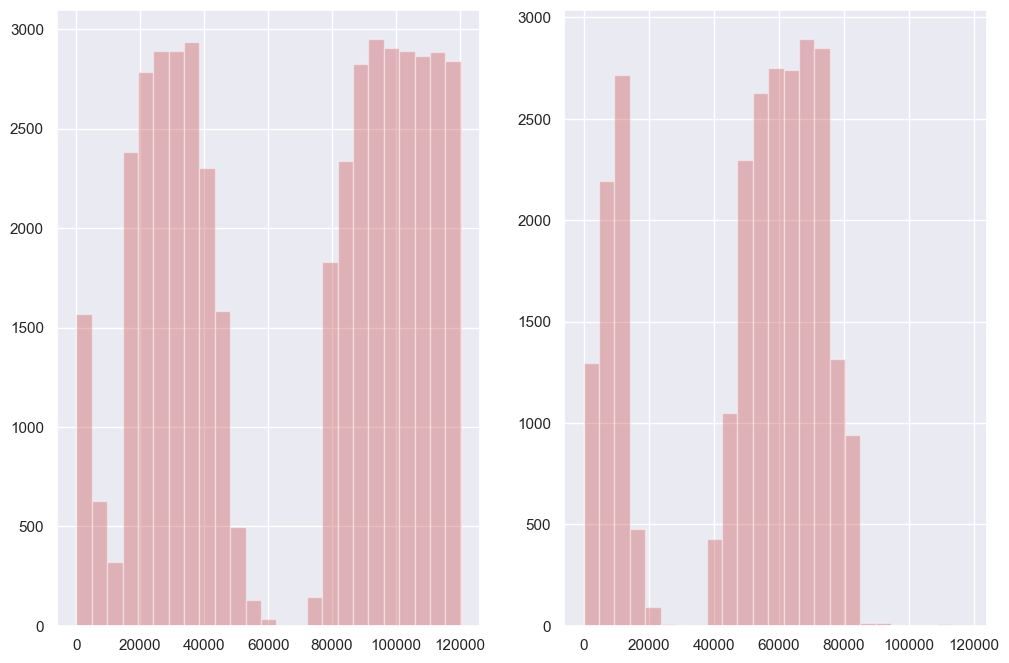

In [22]:
plt.subplot(1, 2, 1)
a1 = train['id'][train['reserva_cancelada']==0]
sns.distplot( x=a1, kde=False, color='indianred', bins=25)

plt.subplot(1, 2, 2)
a2 = train['id'][train['reserva_cancelada']==1]
sns.distplot( x=a2, kde=False, color='indianred', bins=25)

<AxesSubplot:>

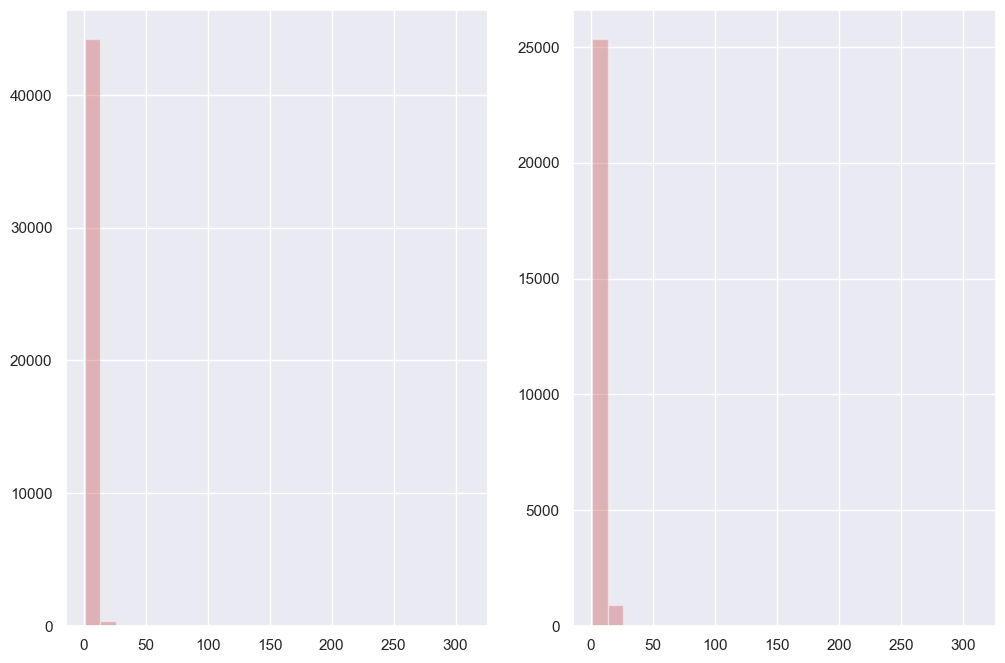

In [23]:
plt.subplot(1, 2, 1)
a1 = train['meses_da_reserva_até_o_check_in'][train['reserva_cancelada']==0]
sns.distplot( x=a1, kde=False, color='indianred', bins=25)

plt.subplot(1, 2, 2)
a2 = train['meses_da_reserva_até_o_check_in'][train['reserva_cancelada']==1]
sns.distplot( x=a2, kde=False, color='indianred', bins=25)

<AxesSubplot:>

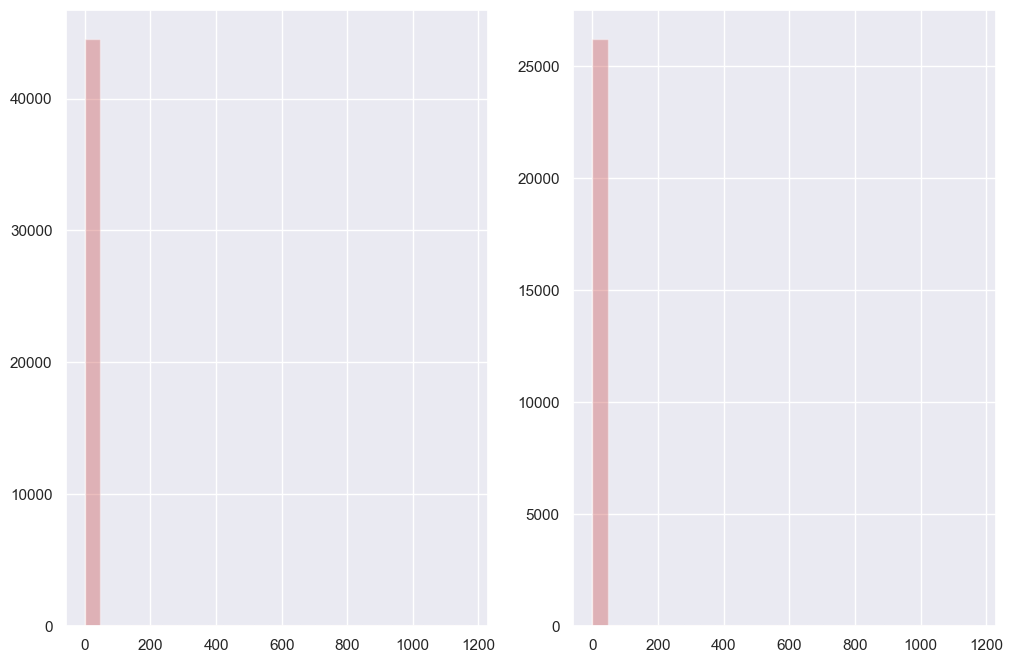

In [24]:
plt.subplot(1, 2, 1)
a1 = train['número_de_pernoites_reservadas'][train['reserva_cancelada']==0]
sns.distplot( x=a1, kde=False, color='indianred', bins=25)

plt.subplot(1, 2, 2)
a2 = train['número_de_pernoites_reservadas'][train['reserva_cancelada']==1]
sns.distplot( x=a2, kde=False, color='indianred', bins=25)

<AxesSubplot:>

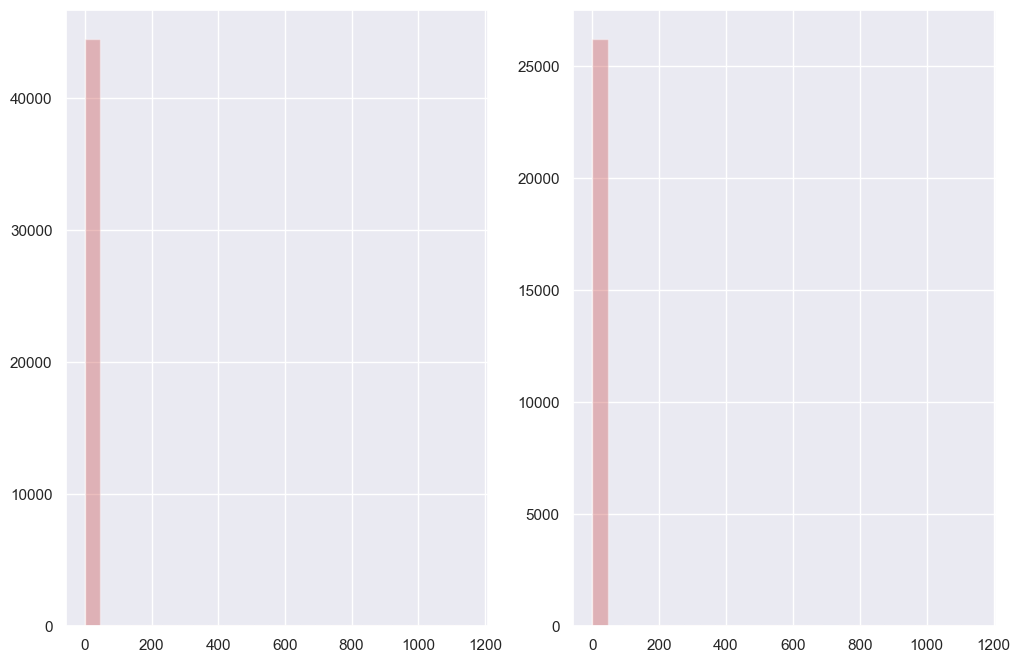

In [25]:
plt.subplot(1, 2, 1)
a1 = train['número_de_hospedes'][train['reserva_cancelada']==0]
sns.distplot( x=a1, kde=False, color='indianred', bins=25)

plt.subplot(1, 2, 2)
a2 = train['número_de_hospedes'][train['reserva_cancelada']==1]
sns.distplot( x=a2, kde=False, color='indianred', bins=25)

### Categóricas

In [26]:
for col in cat_attributes.columns:
    display(pd.crosstab(train[col], train['reserva_cancelada'], normalize='index'))

reserva_cancelada,0.0,1.0
classificação_do_hotel,,
4 estrelas,0.58373,0.41627
5 estrelas,0.72014,0.27986


reserva_cancelada,0.0,1.0
regime_de_alimentação,,
Café da manha,0.627073,0.372927
Café da manha e jantar,0.655919,0.344081
"Café da manha, almoco e jantar",0.398323,0.601677
Sem refeicao,0.632216,0.367784


reserva_cancelada,0.0,1.0
nacionalidade,,
Albania,1.000000,0.000000
Algeria,0.740741,0.259259
American Samoa,1.000000,0.000000
Andorra,0.000000,1.000000
Angola,0.392694,0.607306
Anguilla,1.000000,0.000000
Antarctica,1.000000,0.000000
Argentina,0.736434,0.263566
Armenia,1.000000,0.000000


reserva_cancelada,0.0,1.0
forma_de_reserva,,
Agência,0.589758,0.410242
B2B,0.778821,0.221179
Balcão,0.826126,0.173874


reserva_cancelada,0.0,1.0
já_se_hospedou_anterioremente,,
Não,0.622509,0.377491
Sim,0.848539,0.151461


reserva_cancelada,0.0,1.0
tipo_do_quarto_reservado,,
Amethyst,0.608927,0.391073
Blue Sapphire,0.658247,0.341753
Garnet,0.000000,1.000000
Green Emerald,0.680370,0.319630
Moonstone,1.000000,0.000000
Peridot,0.566489,0.433511
Pink Sapphire,0.713048,0.286952
Red Ruby,0.664921,0.335079
Tanzanite,0.703704,0.296296


reserva_cancelada,0.0,1.0
reserva_feita_por_agência_de_turismo,,
Não,0.753723,0.246277
Sim,0.609909,0.390091


reserva_cancelada,0.0,1.0
reserva_feita_por_empresa,,
Não,0.617807,0.382193
Sim,0.825354,0.174646


reserva_cancelada,0.0,1.0
reserva_com_estacionamento,,
Não,0.60522,0.39478
Sim,1.00000,0.00000


reserva_cancelada,0.0,1.0
reserva_com_observações,,
1 a 3,0.780550,0.219450
Mais de 3,0.915929,0.084071
Nenhuma,0.522847,0.477153


# Pré processamento dos dados

In [27]:
X = train.drop('reserva_cancelada', axis=1)
y = train['reserva_cancelada'].copy()

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Feature Importance

In [28]:
cols_selected = ['meses_da_reserva_até_o_check_in',  'número_de_pernoites_reservadas', 
                 'número_de_hospedes', 'tx_cancel_nacionalidade', 'tx_cancel_regime_de_alimentação',
                 'tx_cancel_forma_de_reserva', 'tx_cancel_tipo_do_quarto_reservado','tx_cancel_reserva_com_observações', 
                 'reserva_feita_por_agência_de_turismo_bin', 'reserva_feita_por_empresa_bin', 
                 'reserva_com_estacionamento_bin', 'classificação_do_hotel_bin']

In [29]:
X_train = train[cols_selected]
y_train = train['reserva_cancelada']

In [30]:
# definição do modelo
trees = ExtraTreesClassifier(n_estimators=250, random_state=42, n_jobs=-1)

trees.fit(X_train, y_train)

ExtraTreesClassifier(n_estimators=250, n_jobs=-1, random_state=42)

Feature ranking:
                                    feature  importance
0                   tx_cancel_nacionalidade    0.255238
0           meses_da_reserva_até_o_check_in    0.215871
0            número_de_pernoites_reservadas    0.168157
0         tx_cancel_reserva_com_observações    0.101547
0                        número_de_hospedes    0.065759
0                tx_cancel_forma_de_reserva    0.045489
0            reserva_com_estacionamento_bin    0.045141
0        tx_cancel_tipo_do_quarto_reservado    0.030750
0           tx_cancel_regime_de_alimentação    0.030148
0                classificação_do_hotel_bin    0.021592
0  reserva_feita_por_agência_de_turismo_bin    0.010295
0             reserva_feita_por_empresa_bin    0.010012


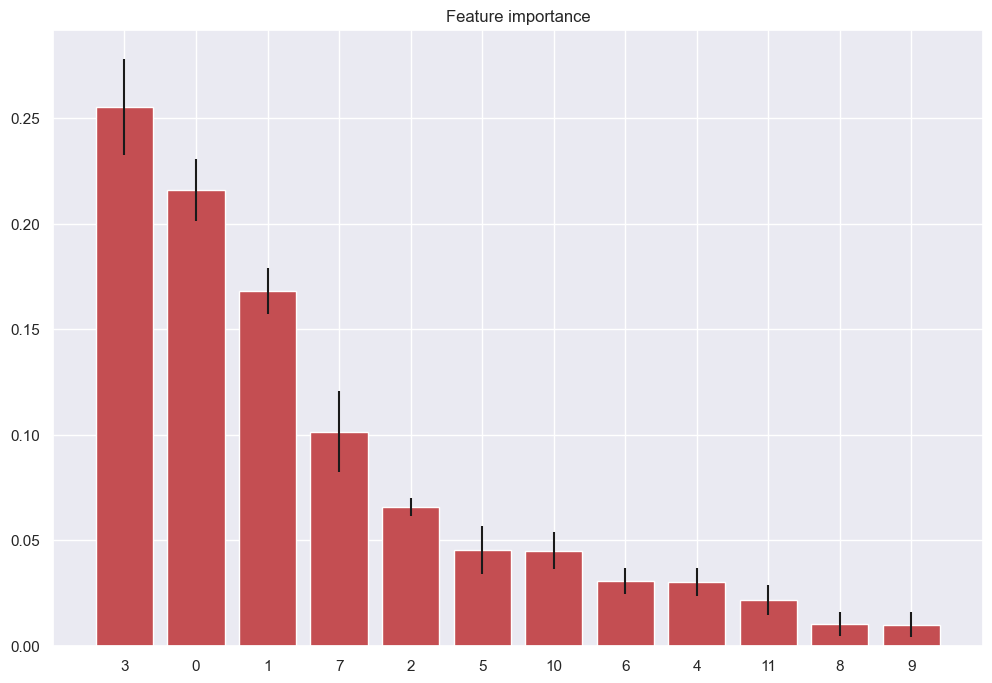

In [31]:
importances = trees.feature_importances_
std = np.std([tree.feature_importances_ for tree in trees.estimators_], axis=0)
indices = np.argsort(importances)[::-1]

# ranking de features
print('Feature ranking:')
df = pd.DataFrame()
for i, j in zip(X_train, importances):
    aux = pd.DataFrame({'feature': i, 'importance': j}, index=[0])
    df = pd.concat([df, aux], axis=0)
    
print(df.sort_values('importance', ascending=False))

# Plot feature importance impurity
plt.figure()
plt.title('Feature importance')
plt.bar(range(X_train.shape[1]), importances[indices], color='r', yerr=std[indices], align='center')
plt.xticks(range(X_train.shape[1]), indices)
plt.xlim([-1, X_train.shape[1]])
plt.show()

# MACHINE LEARNING

In [32]:
X = train[cols_selected]
y= train['reserva_cancelada']

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

## Treinando Modelo - Random Forest

In [33]:
# inicializando estimador
model = RandomForestClassifier(n_estimators=100, n_jobs=-1, random_state=42)

scores = cross_val_score(model, X_train, y_train, cv=5, scoring='f1_macro')

print("F1-score Médio:", scores.mean())

F1-score Médio: 0.7767686573602378


## Treinando Modelo - KNN

In [34]:
# inicializando estimador
model = KNeighborsClassifier()

scores = cross_val_score(model, X_train, y_train, cv=5, scoring='f1_macro')

print("F1-score Médio:", scores.mean())

F1-score Médio: 0.7432991110318122


## Treinando Modelo - SVM

In [35]:
# inicializando estimador
model = SVC(probability = True)

scores = cross_val_score(model, X_train, y_train, cv=5, scoring='f1_macro')

print("F1-score Médio:", scores.mean())

KeyboardInterrupt: 

## Treinando Modelo - XGBOOST

In [ ]:
# inicializando estimador
model = xgb.XGBClassifier(objective='binary:logistic',
                        n_estimators=100,
                        eta=0.01,
                        max_depth=10,
                        subsample=0.7,                       
                        colsample_bytree=0.9)

scores = cross_val_score(model, X_train, y_train, cv=5, scoring='f1_macro')

print("F1-score Médio:", scores.mean())

# OTIMIZAÇÃO HIPERPARAMETROS

# 9 MODELO EM PRODUÇÃO

## Aplicando transformações no teste

In [ ]:
X_test = test

X_test = X_test.fillna(0)

X_test = pd.merge(X_test, tx_cancel_nacionalidade, how="left", on=["nacionalidade", "nacionalidade"])
X_test = pd.merge(X_test, tx_cancel_regime_de_alimentação, how="left", on=["regime_de_alimentação", "regime_de_alimentação"])
X_test = pd.merge(X_test, tx_cancel_forma_da_reserva, how="left", on=["forma_de_reserva", "forma_de_reserva"])
X_test = pd.merge(X_test, tx_cancel_tipo_do_quarto_reservado, how="left", on=["tipo_do_quarto_reservado", "tipo_do_quarto_reservado"])
X_test = pd.merge(X_test, tx_cancel_reserva_com_observações, how="left", on=["reserva_com_observações", "reserva_com_observações"])

X_test['reserva_feita_por_agência_de_turismo_bin'] = X_test['reserva_feita_por_agência_de_turismo'].apply(lambda x: 1 if x == 'Sim' else 0)
X_test['reserva_feita_por_empresa_bin'] = X_test['reserva_feita_por_empresa'].apply(lambda x: 1 if x == 'Sim' else 0)
X_test['reserva_com_estacionamento_bin'] = X_test['reserva_com_estacionamento'].apply(lambda x: 1 if x == 'Sim' else 0)
X_test['classificação_do_hotel_bin'] = X_test['classificação_do_hotel'].apply(lambda x: 1 if x == '5 estrelas' else 0)  

X_test = X_test[cols_selected]

X_test = pt.transform(X_test)

## Predic test

In [ ]:
# predicao_rf = rf.predict(X_test[cols_selected])
predicao_rf = rf.predict(X_test)

## Solucao Final

In [ ]:
df_final_rf = pd.concat([test.id, pd.Series(predicao_rf, name = 'Reserva Cancelada')], axis=1)

df_final_rf['Reserva Cancelada'] = df_final_rf['Reserva Cancelada'].astype('int')
df_final_rf.head()

In [ ]:
#df_final_rf.to_csv('submission6.csv', index=False) #Arquivo de submissão pronto para ser enviado.